# Trend

### What is Trend?

Modelando as mudanças de longo prazo com médias móveis e a dummy de tempo.

O componente de tendência de uma série temporal representa uma mudança persistente e de longo prazo na média da série. A tendência é a parte mais lenta de uma série, a parte que representa a maior escala de tempo de importância. Em uma série temporal de vendas de produtos, uma tendência crescente pode ser o efeito de uma expansão do mercado, à medida que mais pessoas tomam conhecimento do produto ano a ano.

Neste curso, vamos nos concentrar nas tendências da média. Mais geralmente, qualquer mudança persistente e lenta em uma série pode constituir uma tendência - séries temporais geralmente têm tendências em sua variação, por exemplo.

### Moving Average Plots
Para ver que tipo de tendência uma série temporal pode ter, podemos usar um gráfico de média móvel. Para calcular uma média móvel de uma série temporal, calculamos a média dos valores dentro de uma janela deslizante de alguma largura definida. Cada ponto no gráfico representa a média de todos os valores da série que se enquadram na janela de cada lado. A ideia é suavizar quaisquer flutuações de curto prazo na série para que apenas as mudanças de longo prazo permaneçam.

Para visualizar uma tendência, portanto, tomamos uma média de um período maior do que qualquer período sazonal da série.

### Tendência de Engenharia
Uma vez que identificamos a forma da tendência, podemos tentar modelá-la usando um recurso de passo de tempo. Já vimos como usar a próprio dummy de tempo que modelará uma tendência linear:

`alvo = a * tempo + b`

Podemos encaixar muitos outros tipos de tendência através de transformações da dummy de tempo. Se a tendência parece ser quadrática (uma parábola), precisamos apenas adicionar o quadrado da dummy de tempo ao conjunto de recursos, nos dando:

`alvo = a * tempo ** 2 + b * tempo + c`

A regressão linear aprenderá os coeficientes a, b e c.

Se você não viu o truque antes, pode não ter percebido que a regressão linear pode ajustar curvas que não sejam linhas. A ideia é que, se você puder fornecer curvas da forma apropriada como recursos, a regressão linear poderá aprender como combiná-las da maneira que melhor se adequar ao destino.

## Example - Tunnel Traffic

Neste exemplo, criaremos um modelo de tendência para o conjunto de dados de Tráfego de Túnel.

In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("pasta/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

Vamos fazer um gráfico de média móvel para ver que tipo de tendência esta série tem. Como esta série tem observações diárias, vamos escolher uma janela de 365 dias para suavizar quaisquer mudanças de curto prazo dentro do ano.

Para criar uma média móvel, primeiro use o método de `rolling` para iniciar uma computação em janela. Siga isso pelo método da `mean` para calcular a média na janela. Como podemos ver, a tendência do Tráfego de Túnel parece ser linear.

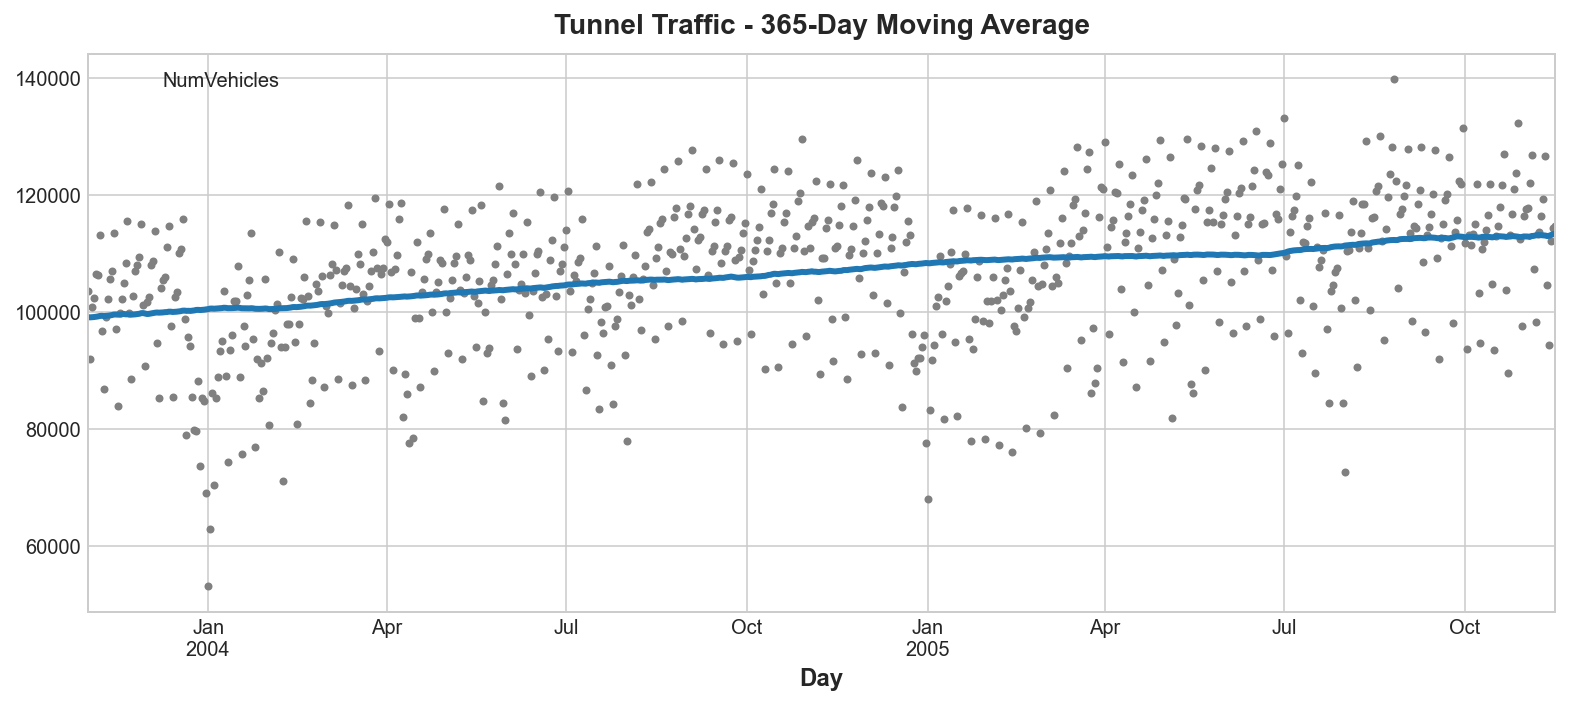

In [2]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

Na Lição 1, projetamos nossa dummy de tempo diretamente no Pandas. A partir de agora, no entanto, usaremos uma função da biblioteca statsmodels chamada DeterministicProcess. Usar esta função nos ajudará a evitar alguns casos de falha complicados que podem surgir com séries temporais e regressão linear. O argumento de ordem refere-se à ordem polinomial: 1 para linear, 2 para quadrático, 3 para cúbico e assim por diante.

In [3]:
from statsmodels.tsa.deterministic import DeterministicProcess
dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()     

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


A propósito, um processo determinístico é um termo técnico para uma série temporal que não é aleatória ou completamente determinada, como as séries const e trend. As características derivadas do índice de tempo geralmente serão determinísticas.

Criamos nosso modelo de tendência basicamente como antes, embora observe a adição do argumento fit_intercept=False.

In [4]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

Day
2003-11-01     98176.206344
2003-11-02     98198.703794
2003-11-03     98221.201243
2003-11-04     98243.698693
2003-11-05     98266.196142
                  ...      
2005-11-12    114869.313898
2005-11-13    114891.811347
2005-11-14    114914.308797
2005-11-15    114936.806247
2005-11-16    114959.303696
Freq: D, Length: 747, dtype: float64

A tendência descoberta pelo nosso modelo LinearRegression é quase idêntica ao gráfico da média móvel, o que sugere que uma tendência linear foi a decisão certa neste caso.

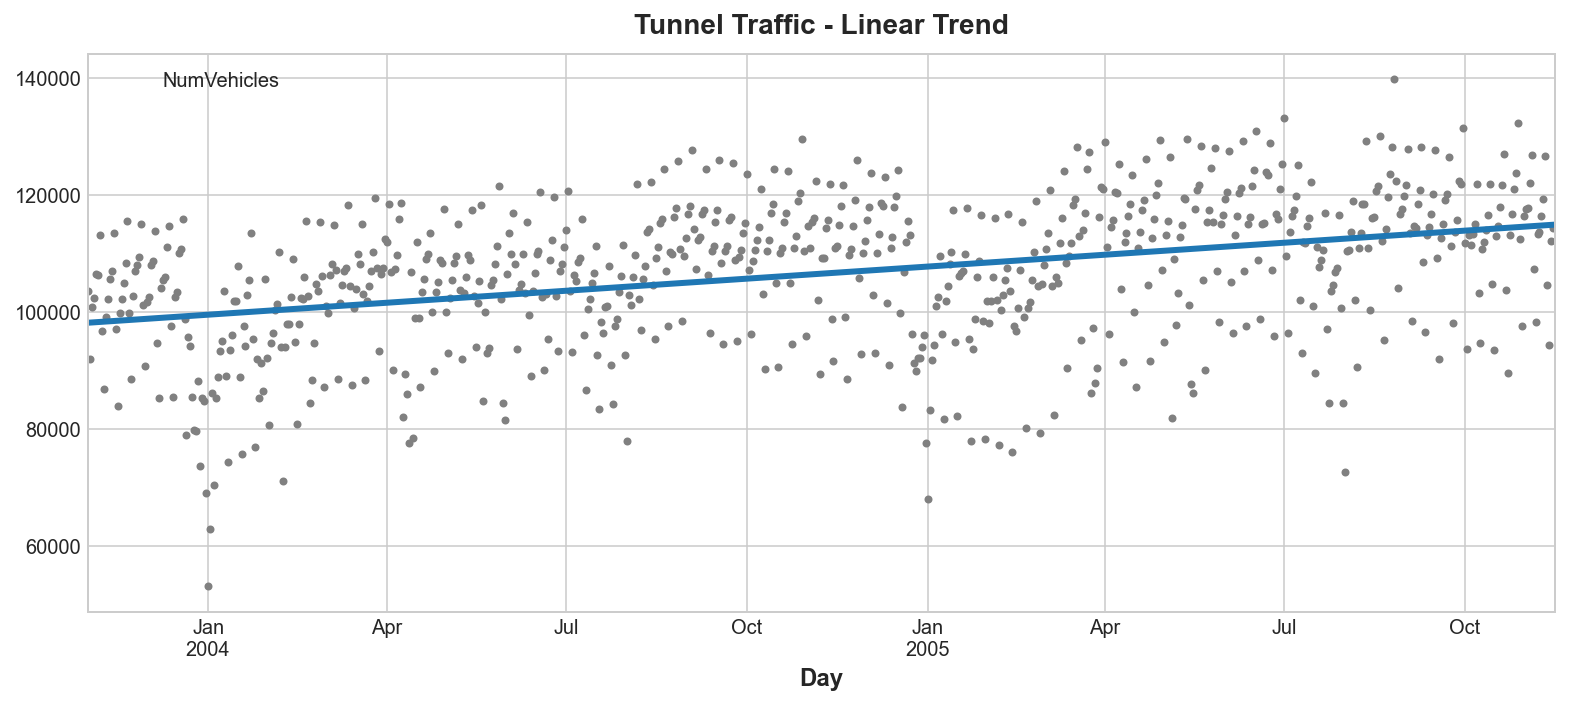

In [5]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

Para fazer uma previsão, aplicamos nosso modelo a recursos "fora da amostra". "Fora da amostra" refere-se a tempos fora do período de observação dos dados de treinamento. Veja como poderíamos fazer uma previsão de 30 dias:

In [6]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Vamos plotar uma parte da série para ver a previsão de tendência para os próximos 30 dias:

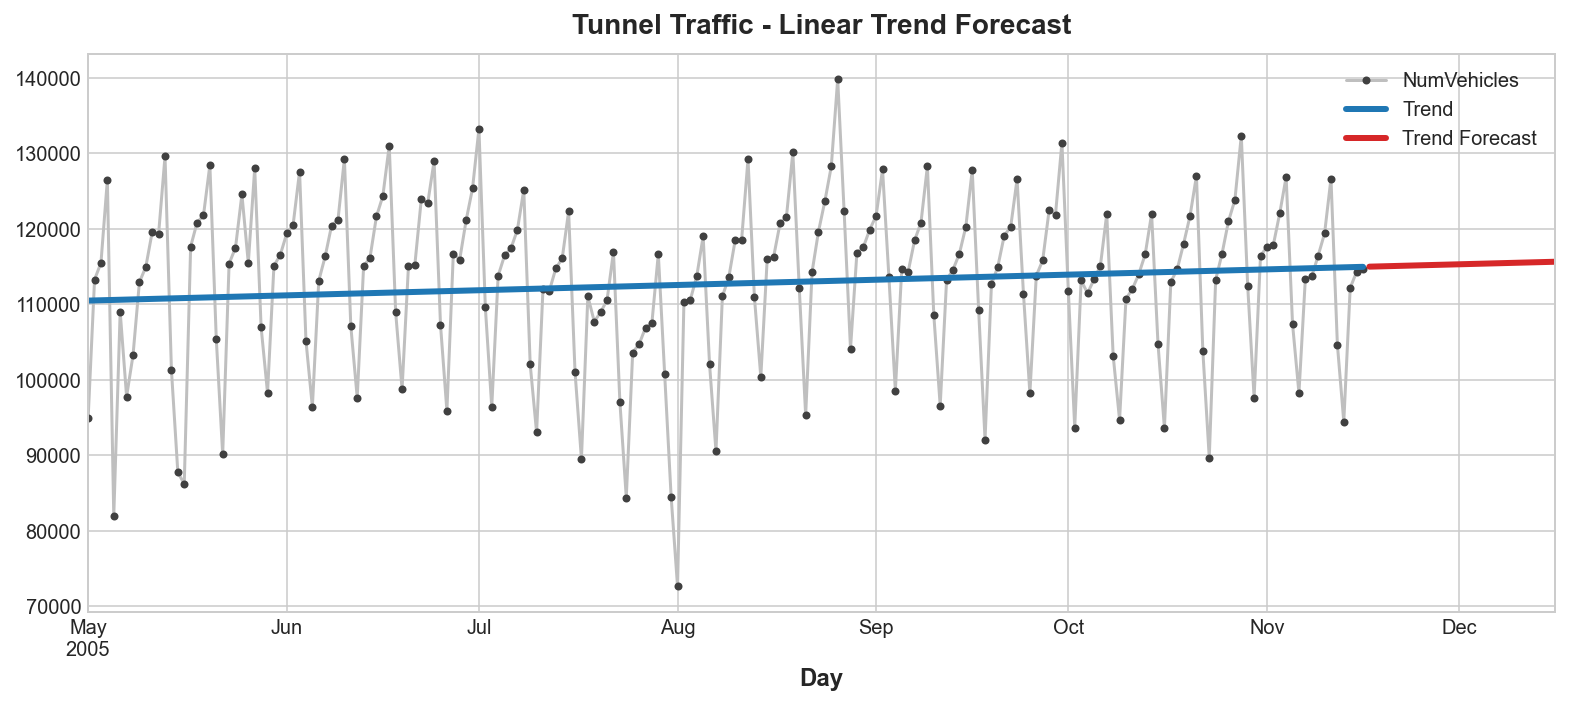

In [7]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

###  Ajustar a tendência com splines

Splines são uma boa alternativa aos polinômios quando você deseja ajustar uma tendência. O algoritmo Multivariate Adaptive Regression Splines (MARS) na biblioteca pyearth é poderoso e fácil de usar. Existem muitos hiperparâmetros que você pode querer investigar.

<img src="img/a.png">

Prever tendências complicadas como essa normalmente será difícil (se não impossível). Com dados históricos, no entanto, você pode usar splines para isolar outros padrões em uma série temporal por eliminação de tendências.

<img src="img/b.png">